In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%load_ext lab_black

import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels as sm
import ppscore as pps
import scipy

sys.path.append("..")
from src.data import make_dataset

output_dirpath = r"..\\data\\raw"

In [2]:
# get the data we need
key = "ELECTRICITY_ACTUALS"
raw_elec_volume_path = os.path.join(output_dirpath, key + ".csv")
if not os.path.isfile(raw_elec_volume_path):
    print("Raw data doesn't exist, so gathering it")
    create_electricity_actuals_dataset(start, end, output_dirpath)

elec = make_dataset.prepare_electricity_actuals(raw_elec_volume_path)
daily_elec_averages = (
    elec[["CCGT", "OCGT"]].fillna(method="ffill").sum(axis=1)
)  # a better way of fillna would be to take the average of the before and after
daily_elec_GWH = daily_elec_averages * 24 / 1000  # convert to a total day GWH

In [3]:
# get the data we need
key = "GAS_VOLUME"
raw_gas_volume_path = os.path.join(output_dirpath, key + ".csv")
if not os.path.isfile(raw_gas_volume_path):
    print("Raw data doesn't exist, so gathering it")
    create_gas_dataset(key, start, end, output_dirpath)

gas_volume = make_dataset.prepare_gas_data(raw_gas_volume_path).rename(
    {"VALUE": "VOLUME"}, axis=1
)
# kWH

gas_volume = make_dataset.map_to_sites(gas_volume)


key = "GAS_CV"
raw_gas_cv_path = os.path.join(output_dirpath, key + ".csv")
if not os.path.isfile(raw_gas_cv_path):
    print("Raw data doesn't exist, so gathering it")
    create_gas_dataset(key, start, end, output_dirpath)

gas_cv = make_dataset.prepare_gas_data(raw_gas_cv_path).rename({"VALUE": "CV"}, axis=1)
# kWH

gas_cv = make_dataset.map_to_sites(gas_cv)

gas_energy = gas_volume.merge(
    gas_cv, left_on=["GAS_DAY", "SITE"], right_on=["GAS_DAY", "SITE"]
)

gas_energy["VOLUME_MULT_CV"] = gas_energy["VOLUME"] * gas_energy["CV"]
gas_energy["ENERGY_GWH"] = gas_energy["VOLUME_MULT_CV"] / 3.6

# calculate the daily average energy for all Powerstations
daily_gas_energy = gas_energy.groupby("GAS_DAY")["ENERGY_GWH"].sum().tz_localize(None)

In [4]:
# get the data we need
df = pd.DataFrame({"ELECTRICITY": daily_elec_GWH, "GAS": daily_gas_energy}).dropna()
df["EFFICIENCY"] = df["ELECTRICITY"] / df["GAS"]
df.head()

,ELECTRICITY,GAS,EFFICIENCY
GAS_DAY,,,
2016-03-14,362.7460,665.422143,0.545137
2016-03-15,392.7550,708.304806,0.554500
2016-03-16,393.2615,716.165089,0.549121
2016-03-17,406.4755,739.237716,0.549858
2016-03-18,407.2865,724.488819,0.562171


In [5]:
def plot_series(timeseries):
    """
    handy plots for a timeseries, histogram and also values over time
    
    Args:
        timeseries (pd.Series) : data to plot
    """
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))

    sns.histplot(timeseries, kde=True, ax=ax[0])
    ax[0].set_title(f"{timeseries.name} Histogram")

    ax[1].plot(timeseries)
    ax[1].set_title(f"{timeseries.name} Over Time")
    plt.show()

# Does Efficiency change seasonally?

In time series analysis, "seasonally" is used generically to mean patterns in data with a certain period. For example we can have yearly seasonality (winter effects) with a period of 365 days, as well as monthly seasonality (month end) with a period of 30 days and weekly seasonality (weekend effects) with a period of 7 days. From first glance, there doesn't seem to be any seasonality in there. If we were looking to simply remove the seasonality and not understand it fully, we would difference the data (look at the difference between today and yesterday).

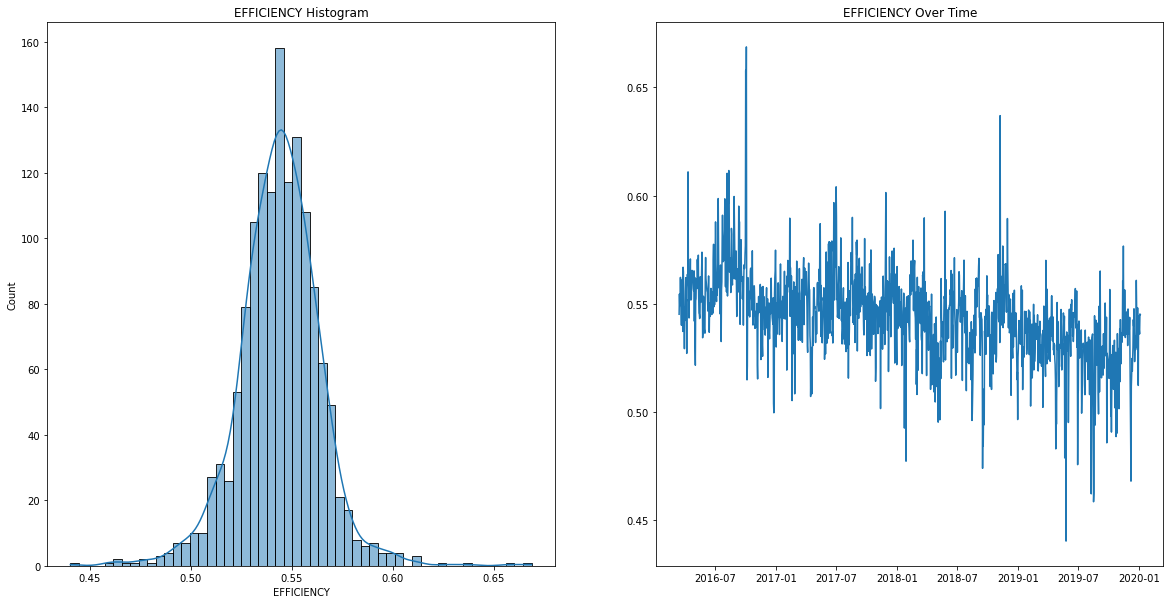

In [6]:
plot_series(df["EFFICIENCY"])

We can begin to decompose any seasonal affects by doing autocorrelation analysis and comparing each value with a lagged version of itself i.e. compare today's value with the value from last week. We see some slight peaking every 7th day which indicates that there is some weekly seasonality in there, but primarily the highest autocorrelation is with yesterday. This means yesterday is similar to today in general.

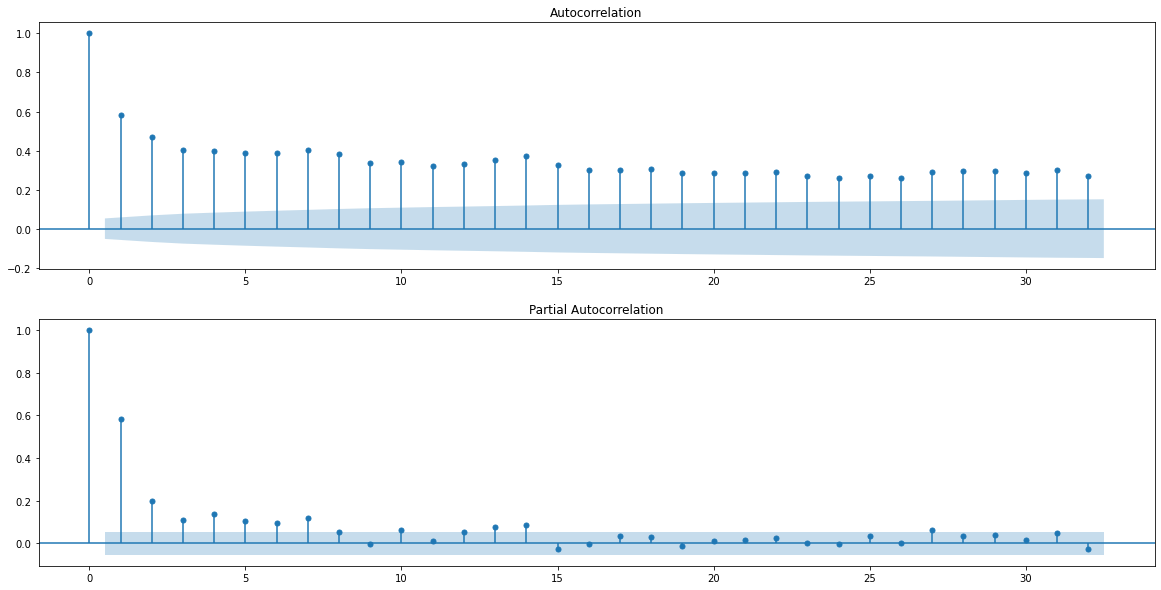

In [7]:
from statsmodels.graphics import tsaplots

fig, ax = plt.subplots(2, 1, figsize=(20, 10))

lags = None

a = tsaplots.plot_acf(df["EFFICIENCY"], lags=lags, ax=ax[0])
b = tsaplots.plot_pacf(df["EFFICIENCY"], lags=lags, ax=ax[1])

A more complex method is to build an additive model to understand various seasonal components, the facebook prophet library does this very well but let's start with a simple seasonal_decompose. This doesn't show much other than a slight downward trend. Residuals are in and around =/- 5% which looks okay!

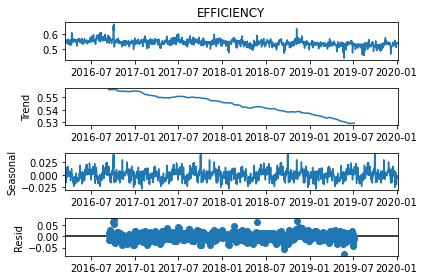

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonality = seasonal_decompose(df["EFFICIENCY"], model="additive", period=365)

a = seasonality.plot()

In [9]:
# from prophet import Prophet
#
# proph_data = df["EFFICIENCY"].reset_index()
# proph_data = proph_data.rename({"GAS_DAY" : "ds", "EFFICIENCY" : "y"}, axis=1)
#
# m = Prophet()
# m.fit()
#
# future = m.make_future_dataframe(periods=365)
#
# forecast = m.predict(future)
#
#
# fig2 = m.plot_components(forecast)

To further examine seasonality, we could explore a bunch of different things:
- More detailed seasonal decomposition
- Adding seasonal features (like day of the week, month, season) to the data to visualise and test
- do a fourier transform and examine its components

I'm going to try something a little out the box, and use the number of daylight hours to represent seasonality and examine any correlation there.

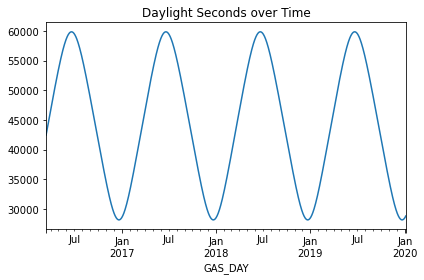

In [18]:
from astral import LocationInfo
from astral.sun import sun


# set location to get sun data for
city = LocationInfo("London", "England", "Europe/London", 51.5, -0.116)


date_list = df.index

days = []
for adate in date_list:
    day = sun(city.observer, date=adate)
    day = pd.DataFrame(day, index=[adate.date()])
    days.append(day)

sundata = pd.concat(days)
sundata.index.name = "GAS_DAY"
sundata["DAYLIGHT_HOURS"] = sundata["sunset"] - sundata["sunrise"]
sundata["DAYLIGHT_SECONDS"] = sundata["DAYLIGHT_HOURS"].dt.total_seconds()

df = df.merge(
    sundata["DAYLIGHT_SECONDS"], how="left", left_index=True, right_index=True
)

fig, ax = plt.subplots()

df["DAYLIGHT_SECONDS"].plot(ax=ax)
plt.title("Daylight Seconds over Time")
plt.tight_layout()
plt.show()

We can see that the electricity and gas usage (which is linked to electricity demand) is inversely correlated with the daylight hours, i.e. when there is more daylight there is less electricity demand - which makes sense. There doesn't seem to be much visible with efficiency.

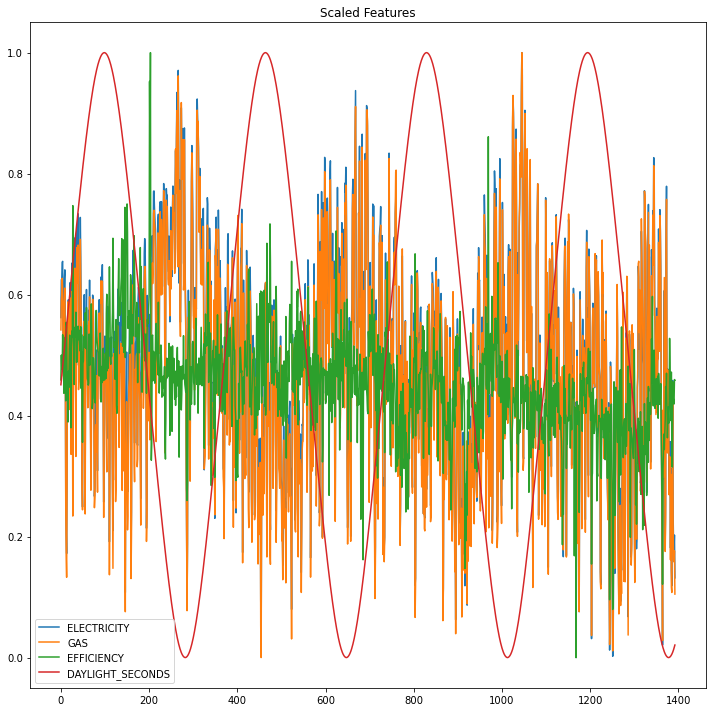

In [24]:
from sklearn.preprocessing import MinMaxScaler

x = df.values  # returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_scaled = pd.DataFrame(x_scaled, columns=df.columns)

fig, ax = plt.subplots(figsize=(10, 10))

df_scaled.plot(ax=ax)
plt.title("Scaled Features")
plt.tight_layout()
plt.show()

In [25]:
df.corr()

,ELECTRICITY,GAS,EFFICIENCY,DAYLIGHT_SECONDS
ELECTRICITY,1.000000,0.992647,0.208363,-0.313028
GAS,0.992647,1.000000,0.093784,-0.320732
EFFICIENCY,0.208363,0.093784,1.000000,0.043402
DAYLIGHT_SECONDS,-0.313028,-0.320732,0.043402,1.000000


# How does Temperature interact?

In [ ]:
key = "temperature"
raw_temp_path = os.path.join(output_dirpath, key + ".csv")
if not os.path.isfile(raw_temp_path):
    print("Raw data doesn't exist, so gathering it")
    create_gas_dataset(key, start, end, output_dirpath)


temperature = make_dataset.prepare_gas_data(
    raw_temp_path, keep_powerstations_only=False,
)
temperature = temperature.groupby("GAS_DAY")["VALUE"].mean().rename("TEMPERATURE")

In [ ]:
plot_series(temperature)

## Does Temperature affect Efficiency?

We can look at this in various ways, statistically with correlation analysis, or a multitude of various statistical tests but sometimes the best way to look at things is to simply visualise the data. Looking at the data we don't see any clear relationships between temperature and efficiency.

In [ ]:
df = df.merge(temperature, how="left", left_on="GAS_DAY", right_on="GAS_DAY")
df = df[df.index.year > 2017]

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(10, 10))

sns.scatterplot(data=df, x="TEMPERATURE", y="EFFICIENCY", ax=ax[0])
ax[0].set_title("Temperature vs Average Powerstation Efficiency")

sns.scatterplot(data=df.pct_change(), x="TEMPERATURE", y="EFFICIENCY", ax=ax[1])
ax[1].set_title(
    "Percent Change in Temperature vs Percent Change in Powerstation Efficiency"
)

sns.scatterplot(data=df.diff(), x="TEMPERATURE", y="EFFICIENCY", ax=ax[2])
ax[2].set_title(
    "Daily Change in Temperature vs Daily Change in Powerstation Efficiency"
)

plt.tight_layout()
plt.show()

## with CV?

# Archive

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

sns.lineplot(
    data=gas_energy[gas_energy["POWERSTATION"]].dropna(),
    x="GAS_DAY",
    y="ENERGY",
    hue="SITE",
    ax=ax,
)

In [ ]:
gas_cv = make_dataset.prepare_gas_data(
    r"C:\Users\rachel.hassall\git\charterful\data\raw\GAS_CV.csv"
).rename({"VALUE": "CV"}, axis=1)
gas_cv = gas_cv[gas_cv["CV"] <= 43][37.5 <= gas_cv["CV"]]
cv_item_mapping = {}
for item in gas_cv["ITEM"].unique():
    try:
        site = item.split(",")[1].strip()
        cv_item_mapping[item] = site
    except:
        print(item)
gas_cv["SITE"] = gas_cv["ITEM"].map(cv_item_mapping)

In [ ]:
volume_item_mapping = {}
for item in volume["ITEM"].unique():
    try:
        site = item.split(",")[1].strip()
        volume_item_mapping[item] = site
    except:
        print(item)

volume["SITE"] = volume["ITEM"].map(volume_item_mapping)

In [ ]:
gas = pd.merge(volume, gas_cv, on=["SITE", "GAS_DAY"], suffixes=("_VOLUME", "_CV"))
gas["ENERGY_MJ"] = (gas["VOLUME"] / 1000000) * gas["CV"]

# M M3 * MJ/m3.

In [ ]:
gas

In [ ]:
daily_gas_volumes = (
    gas[gas["POWERSTATION_VOLUME"]].groupby("GAS_DAY")["VOLUME"].sum().tz_localize(None)
)

In [ ]:
daily_gas_cv = (
    gas[gas["POWERSTATION_CV"]].groupby("GAS_DAY")["CV"].mean().tz_localize(None)
)

In [ ]:
daily_gas_MJ = (
    gas[gas["POWERSTATION_CV"]].groupby("GAS_DAY")["ENERGY_MJ"].sum().tz_localize(None)
)

In [ ]:
daily_gas_GWH = daily_gas_volumes * 10.895

Similarly, seasonality is visible in the power station gas demand. There appear to be anomalies in the peak demeand at the start of every year, suggesting a possible accounting error and will be removed from further analysis.

In [ ]:
plot_series(daily_gas_MJ.rename("Gas (MJ)"))

In [ ]:
plot_series(daily_gas_GWH.rename("Gas (GWH)"))

In [ ]:
daily_gas_GWH = daily_gas_GWH[daily_gas_GWH < 1250]

## Does Calorific Value affect Efficiency?

Calorific value (CV) is a measure of heating power and is dependent upon the composition of the gas. The CV refers to the amount of energy released when a known volume of gas is completely combusted under specified conditions. The CV of gas, which is dry, gross and measured at standard conditions of temperature (15oC) and pressure (1013.25 millibars), is usually quoted in megajoules per cubic metre (MJ/m3). Gas passing through our pipeline system has a CV of 37.5 MJ/m3 to 43.0 MJ/m3.

[https://www.nationalgrid.com/uk/gas-transmission/data-and-operations/calorific-value-cv]

In [ ]:
gas_cv = make_dataset.prepare_gas_data(
    r"C:\Users\rachel.hassall\git\charterful\data\raw\GAS_CV.csv"
)
gas_cv = gas_cv[gas_cv["VALUE"] != 0]
daily_gas_cv = (
    gas_cv[gas_cv["POWERSTATION"]].groupby("GAS_DAY")["VALUE"].mean().tz_localize(None)
)
df = df.merge(daily_gas_cv.rename("CV"), how="left", left_index=True, right_index=True)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

sns.lineplot(
    data=gas_cv[gas_cv["POWERSTATION"]][["GAS_DAY", "ITEM", "VALUE"]],
    x="GAS_DAY",
    y="VALUE",
    hue="ITEM",
    ax=ax,
    palette="Set2",
)
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0)

In [ ]:
plot_series(df["CV"].rename("Calorific Value"))

In [ ]:
plt.scatter(df["CV"], df["EFFICIENCY"])
plt.title("CV vs Powerstation Efficiency")
plt.show()